# Crafting a Story from Data

## Leo Evancie | Springboard Data Science Career Track

I chose to examine cases of alleged misconduct by agents of the Transportation Security Administration's Federal Air Marshal Service (FAMS). ProPublica's article on the subject can be found <a href=https://www.propublica.org/article/tsa-releases-data-on-air-marshal-misconduct-7-years-after-we-asked>here</a><sup>[1]</sup>. ProPublica obtained the source data from the TSA via a Freedom of Information Act request (fulfilled after a seven-year delay). ProPublica made the data freely available <a href=https://www.propublica.org/datastore/dataset/federal-air-marshal-misconduct-database>here</a></a><sup>[2]</sup>, accompanied by the following summary:

> _"Federal air marshals fly undercover on passenger planes and are trained to intervene in the event of a hijacking. This database contains information on 5,214 cases of misconduct committed by federal air marshals by date and field office and what discipline was meted out in response. The data covers November 2002 to February 2012."_

Six columns comprise the data:
- `Record #`
- `Field Office`
- `Allegation`
- `Date Case Opened`
- `Year`
- `Final Disposition`

I am interested in the following questions:
1. How has the number of reported incidents changed over time?
2. Do some field offices see disproportionately high or low case numbers?
3. What kinds of allegations make up the data, and in what proportions?
4. Is there a relationship between the type of allegation and the final outcome?

### 0. Load and clean

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fams = pd.read_excel('FAMS Misconduct Database.xlsx')
fams.head()

,Record #,Field Office,Allegation,Date Case Opened,Year,Final Disposition
0,2,HOU,Failure to Follow Procedure,2002-11-06,2002,Verbal Counsel
1,7,DAL,Unprofessional Conduct,2002-11-12,2002,Suspension - 1 Day
2,13,MSP,Loss of Equipment,2002-11-12,2002,Letter of Counsel
3,27,LAS,Failure to Honor Just Debts,2002-11-01,2002,Verbal Counsel
4,46,LAS,Failure to Honor Just Debts,2002-11-23,2002,Resignation


In [2]:
fams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5213 entries, 0 to 5212
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Record #           5213 non-null   int64         
 1   Field Office       5204 non-null   object        
 2   Allegation         5213 non-null   object        
 3   Date Case Opened   5213 non-null   datetime64[ns]
 4   Year               5213 non-null   int64         
 5   Final Disposition  5208 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 244.5+ KB


In [3]:
# Dropping the scattered few records with missing values
fams = fams.dropna()
fams.shape

(5199, 6)

In [4]:
# Cleaning up column names
fams.rename(columns={'Field Office ':'Field Office',
                  'Allegation ':'Allegation',}, inplace=True)

# Removing trailing spaces from string columns
fams_strs = fams.select_dtypes(['object'])
fams[fams_strs.columns] = fams_strs.apply(lambda x: x.str.strip())

# Handling capitalization errors from data entry (e.g., 'lAX')
fams['Field Office'] = fams['Field Office'].apply(lambda x: x.upper())
fams[['Allegation', 'Final Disposition']] = fams[['Allegation', 'Final Disposition']].apply(lambda x: x.str.lower())

# Converting the many 'suspension' entries (with varying durations) to a common value
fams['Final Disposition'] = fams['Final Disposition'].apply(lambda x: x[:10] if x[0] == 's' else x)

# Correcting the presumably erroneous 'WFO' to 'SFO'
fams = fams.replace('WFO', 'SFO')

### 1. How has the number of reported cases changed over time?

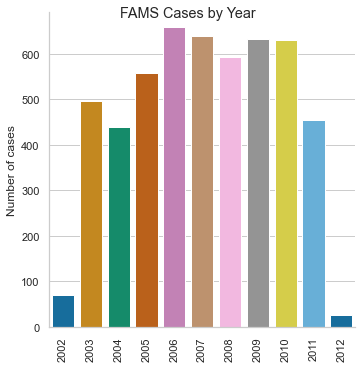

In [5]:
cases_by_year = fams.groupby(by='Year', sort=True)['Record #'].count().reset_index()
cases_by_year.rename(columns={'Record #':'Cases'}, inplace=True)

sns.set_style('whitegrid')
sns.set_context('notebook')

ax = sns.catplot(x='Year',y='Cases', kind='bar', data=cases_by_year, palette='colorblind')
ax.fig.suptitle('FAMS Cases by Year')
ax.set_axis_labels("","Number of cases")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.savefig('figures/cases-by-year.png', bbox_inches='tight', dpi=100)
plt.show()

Since the data run from Nov 2002 to Feb 2012, we should interepret the low numbers of cases in those years as such. Cases are at their highest from 2006 through 2011 after having some fluctuation in the early years. There is a considerable dropoff in cases from 2010 to 2011.

### 2. How do case numbers vary by location?

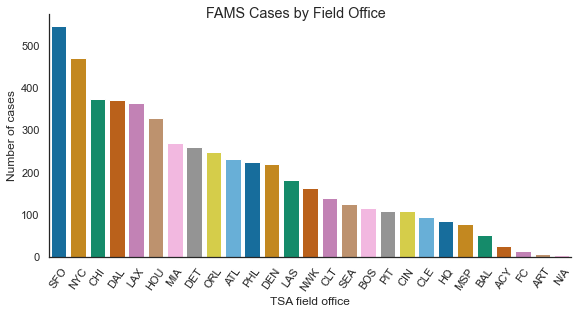

In [8]:
cases_by_office = fams.groupby(by='Field Office', sort=True)['Record #'].count().reset_index()
cases_by_office.rename(columns={'Record #':'Cases'}, inplace=True)
cases_by_office.sort_values(by='Cases', ascending=False, inplace=True)

ax = sns.catplot(x='Field Office',y='Cases', kind='bar', data=cases_by_office, palette='colorblind', height=4, aspect=2)
ax.fig.suptitle('FAMS Cases by Field Office')
ax.set_axis_labels("TSA field office","Number of cases")
locs, labels = plt.xticks()
plt.setp(labels, rotation=55)
plt.savefig('figures/cases-by-office.png', bbox_inches='tight', dpi=110)
plt.show()

Naturally, busier air traffic hubs correspond to more cases; there are simply more flights, and thus more agents. I would note that Atlanta (ATL), typically the country's busiest airport, is actually somewhere in the middle of the pack here. San Francisco and NYC (the latter serving JFK and LGA collectively, presumably as well as Newark) are the clear standouts. I would speculate that with so many international flights into and out of the West Coast and New York hubs, and with air marshals presumably accompanying international flights more frequently than domestic flights, these numbers are to be expected. Aside from ATL as noted, I do not see any jarring exceptions, where a busy market generates surprisingly few cases of misconduct, nor vice versa.

### 3. What are the air marshals being reported for?

In [9]:
fams['Allegation'].value_counts()

loss of equipment                         1226
missed mission                             953
failure to follow procedure                509
unprofessional conduct                     453
failure to honor just debts                417
criminal arrest                            148
misuse of government travel card           145
miscellaneous                              140
absent without leave                       112
failure to follow instruction               89
abuse of position/authority                 82
falsification of records                    77
sleeping on duty                            74
making misstatements/false                  72
international security screening            69
ssi/classified material violation           59
criminal conduct                            58
sick leave violation                        57
alcohol policy violation                    51
fighting, threatening, or intimidating      49
hotel compliance                            33
misuse of gov

These infractions run the gamut from mundane (e.g., 'unexcused tardiness') to serious (e.g., unintentional discharge of firearm, sexual harrassment). I will define a list of what appear to be serious violations, including apparently criminal actions or otherwise fireable offenses in most professional contexts.

Note: 'discharge of firearm' and 'unintentional discharge of firearm' are listed as separate types of infraction. This could be a data quality issue, or it could be the case that complaints were lodged against agents who intentionally, but perhaps wrongly, discharged their firearms. (If an agent intentionally and appropriately discharged their firearm, that does not seem as likely to generate a _misconduct_ complaint.) For lack of deeper context, I will include both in my list.

In [10]:
serious_allegations = [
    'criminal arrest',
    'criminal conduct',
    'fighting, threatening, or intimidating',
    'sexual harassment',
    'unintentional discharge of firearm',
    'discharge of firearm',
    'security/safety violation',
    'leo action', # 'leo' = law enforcement officer
    'drug policy violation',
    'discharge of firearm',
]

print(len(fams[fams['Allegation'].isin(serious_allegations)]), 'serious allegations reported')
print(round(100*len(fams[fams['Allegation'].isin(serious_allegations)])/len(fams),2), '% of reported cases were serious')

357 serious allegations reported
6.87 % of reported cases were serious


### 4. How does allegation relate to outcome?

First, I will check the overall breakdown of outcomes for all cases.

In [11]:
fams['Final Disposition'].value_counts()

letter of counsel                      1833
suspension                              933
letter of reprimand                     755
no further action                       648
resignation                             366
verbal counsel                          364
removal                                 250
retirement                               30
last chance agreement                     6
deceased                                  5
demotion                                  3
letter of guidance and direction          3
leave restriction letter                  1
other (sealed settlement agreement)       1
expiration of appt                        1
Name: Final Disposition, dtype: int64

By far, the most common outcome is a letter of counsel. With "letter of reprimand" listed separately, we can assume that a letter of counsel is a milder action, essentially a written warning.

But what's the deal with the 'death' allegations and the 'deceased' final outcomes? Why would an agent's death be the subject of a misconduct complaint? Do such complaints automatically result in the 'deceased' final disposition, whereby those are the only cases with that outcome?

In [12]:
fams[(fams['Allegation']=='death') | (fams['Final Disposition']=='deceased')]

,Record #,Field Office,Allegation,Date Case Opened,Year,Final Disposition
74,136,SEA,death,2002-12-30,2002,no further action
1739,1829,ORL,falsification of records,2006-04-06,2006,deceased
1973,2071,ORL,death,2006-08-25,2006,deceased
3250,3373,DEN,loss of equipment,2008-08-25,2008,deceased
3669,3815,DEN,missed mission,2009-04-18,2009,deceased
3700,3847,DEN,management inquiry,2009-05-05,2009,deceased
3710,3857,LAX,death,2009-05-11,2009,no further action
4429,4646,LAX,death,2010-07-31,2010,no further action


This is a bit curious! In only one case of a 'death' allegation, the final disposition is 'deceased'. The other 'death' cases result in 'no further action'. Yet there are four other cases where the outcome is 'deceased', but the allegation is _not_ 'death'. I can only speculate that such cases either reflect data entry errors, or agents dying before the TSA could resolve their (unrelated) case.

Now I want to see what allegations lead to what outcomes. With 39 unique allegations and 15 unique outcomes, I will simplify the categories for a more legible visualization.

First, I will select only the 10 most common allegations, to get a sense of how the most typical cases are handled. For further simplification, I will also select for cases with the 7 most common outcomes, as there are very few of each of the remaining outcomes, many of which do not appear to disciplinary action (e.g., retirement).

In [33]:
allegations_to_include = set(list(fams['Allegation'].value_counts()[:10].index))
outcomes_to_include = list(fams['Final Disposition'].value_counts()[:7].index)

# Pivot allegations and outcomes, remove redundant columns resulting from hierarchical indexing
outcomes_common_allegation = pd.pivot_table(fams, index='Allegation', columns='Final Disposition', aggfunc='count', fill_value=0).iloc[:, :15]
# Remove hierarchical column index
outcomes_common_allegation.columns = outcomes_common_allegation.columns.get_level_values(1)
# Select outcomes and allegations of interest
outcomes_common_allegation = outcomes_common_allegation[outcomes_to_include].reset_index()
outcomes_common_allegation = outcomes_common_allegation[outcomes_common_allegation['Allegation'].isin(allegations_to_include)]
outcomes_common_allegation.index=outcomes_common_allegation['Allegation']
outcomes_common_allegation.drop('Allegation', axis=1, inplace=True)
# Define a Totals column to sort, then remove
outcomes_common_allegation['Total'] = outcomes_common_allegation.sum(axis=1)
outcomes_common_allegation.sort_values(by='Total', inplace=True)
outcomes_common_allegation.drop('Total', axis=1, inplace=True)
# Convert from counts to percentages
outcomes_common_allegation_pct = outcomes_common_allegation.div(outcomes_common_allegation.sum(axis=1), axis=0)*100
outcomes_common_allegation_pct

Final Disposition,letter of counsel,suspension,letter of reprimand,no further action,resignation,verbal counsel,removal
Allegation,,,,,,,
failure to follow instruction,26.190476,26.190476,14.285714,7.142857,11.904762,4.761905,9.523810
absent without leave,28.828829,25.225225,17.117117,3.603604,15.315315,2.702703,7.207207
miscellaneous,12.230216,4.316547,4.316547,55.395683,7.194245,11.510791,5.035971
criminal arrest,5.594406,25.874126,13.286713,11.188811,22.377622,0.699301,20.979021
misuse of government travel card,18.055556,25.694444,13.888889,4.166667,22.222222,2.777778,13.194444
failure to honor just debts,20.673077,27.403846,20.673077,4.086538,12.740385,9.855769,4.567308
unprofessional conduct,20.224719,23.370787,11.460674,22.247191,7.191011,8.314607,7.191011
failure to follow procedure,33.663366,11.683168,13.861386,22.376238,4.356436,11.485149,2.574257
missed mission,53.361345,14.600840,20.798319,2.100840,3.361345,3.886555,1.890756


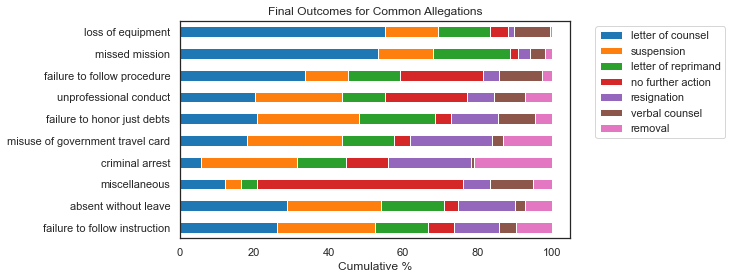

In [38]:
outcomes_common_allegation_pct.plot(kind='barh', stacked=True)
fig = plt.gcf()
fig.set_size_inches(7,4)
#fig.set_cmap('Pastel1')
plt.legend(bbox_to_anchor=(1.05,1))
plt.title('Final Outcomes for Common Allegations')
plt.xlabel('Cumulative %')
plt.ylabel('')
plt.savefig('figures/outcomes-for-common-allegations.png', bbox_inches='tight', dpi=100)
plt.show()

It would appear that the letter of counsel accounts for about half of all cases involving a loss of equipment or a missed mission, and closer to a quarter of the other common allegations, except for criminal arrest. Suspension, resignation, removal, and letter of reprimand account for the majority of outcomes aside from the letter of counsel, for most common allegations. However, the TSA occasionally takes no further action on the allegation, especially with regard to the catch-all "miscellaneous" allegation.

It's important to bear in mind that the total number of allegations in each of the bars above drops off quickly as we move down the list. Loss of equipment, remember is by far the most common type at 1,800 out of ~5000, while failure of instruction only appears 89 times.

I will now recreate the above visualization, this time selecting the serious allegations rather than the most common. This will illustrate how the TSA meted out consequences for only those cases which involved alleged criminal wrongdoing or other grave offenses. This time, I will not narrow down the selection of possible outcomes, because I want a more exact readout of the consequences for these allegations.

In [40]:
# Pivot allegations and outcomes, remove redundant columns resulting from hierarchical indexing
outcomes_serious_allegation = pd.pivot_table(fams, index='Allegation', columns='Final Disposition', aggfunc='count', fill_value=0).iloc[:, :15]
# Remove hierarchical column index
outcomes_serious_allegation.columns = outcomes_serious_allegation.columns.get_level_values(1)
# Select allegations of interest
outcomes_serious_allegation.reset_index(inplace=True)
outcomes_serious_allegation = outcomes_serious_allegation[outcomes_serious_allegation['Allegation'].isin(serious_allegations)]
outcomes_serious_allegation.index=outcomes_serious_allegation['Allegation']
outcomes_serious_allegation.drop('Allegation', axis=1, inplace=True)
# Define a Totals column to sort, then remove
outcomes_serious_allegation['Total'] = outcomes_serious_allegation.sum(axis=1)
outcomes_serious_allegation.sort_values(by='Total', inplace=True)
outcomes_serious_allegation.drop('Total', axis=1, inplace=True)
# Convert from counts to percentages
outcomes_serious_allegation_pct = outcomes_serious_allegation.div(outcomes_serious_allegation.sum(axis=1), axis=0)*100
outcomes_serious_allegation_pct
# Drop outcomes (i.e., columns) corresponding to zero cases in the selected data
cols_to_drop = [col for col in outcomes_serious_allegation_pct.columns if outcomes_serious_allegation_pct[col].sum()==0]
outcomes_serious_allegation_pct.drop(columns=cols_to_drop, axis=1, inplace=True)
outcomes_serious_allegation_pct

Final Disposition,last chance agreement,letter of counsel,letter of reprimand,no further action,removal,resignation,retirement,suspension,verbal counsel
Allegation,,,,,,,,,
discharge of firearm,0.000000,25.000000,0.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000
drug policy violation,0.000000,0.000000,0.000000,16.666667,41.666667,41.666667,0.000000,0.000000,0.000000
leo action,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
security/safety violation,0.000000,8.333333,8.333333,16.666667,0.000000,8.333333,0.000000,58.333333,0.000000
sexual harassment,0.000000,22.580645,6.451613,22.580645,9.677419,16.129032,0.000000,19.354839,3.225806
unintentional discharge of firearm,0.000000,12.903226,6.451613,6.451613,6.451613,12.903226,0.000000,51.612903,3.225806
"fighting, threatening, or intimidating",2.040816,2.040816,6.122449,36.734694,16.326531,16.326531,0.000000,16.326531,4.081633
criminal conduct,0.000000,27.586207,3.448276,44.827586,6.896552,6.896552,0.000000,5.172414,5.172414
criminal arrest,0.675676,5.405405,12.837838,10.810811,20.270270,21.621622,2.702703,25.000000,0.675676


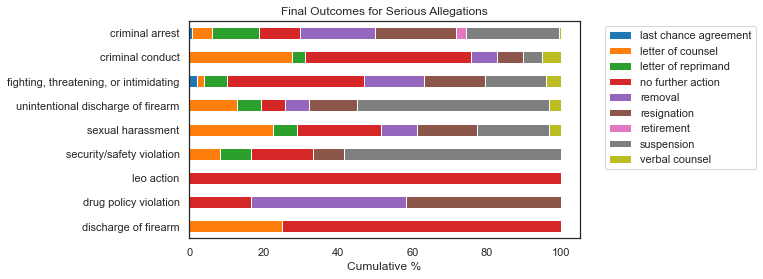

In [41]:
outcomes_by_allegation_pct.plot(kind='barh', stacked=True)
fig = plt.gcf()
fig.set_size_inches(7,4)
#fig.set_cmap('Pastel1')
plt.legend(bbox_to_anchor=(1.05,1))
plt.title('Final Outcomes for Serious Allegations')
plt.xlabel('Cumulative %')
plt.ylabel('')
plt.savefig('figures/outcomes-for-serious-allegations.png', bbox_inches='tight', dpi=100)
plt.show()

First, I will again note that these bars represent cumulative percentages, and that no one serious allegation corresponds to more than 100 of the more than 5,000 reported cases.

Having noted the caveat that some of the denominators here are quite small, we can better contextualize, for example, the fact that 100% of the cases involving law enforcement action resulted in no further action; there were only 12 such cases.

Still, we can see some differences between the graph above and that of the common allegations. Namely, we see smaller proportions of cases resulting in a letter of counsel. Meanwhile, we see decent proportions of cases resulting in agent resignation or removal, particularly cases involving criminal arrest or drug policy violation. More than half of cases involving unintentional firearm dischage and security/safety violation resulted in suspension.

I would note that 'no further action' is still represented highly among these serious allegations, especially in cases of discharge of firearm, criminal conduct, and fighting/threatening/intimidating.

### 5. Conclusions

The TSA receives misconduct complaints against agents of the Federal Air Marshal Service (FAMS) for a wide range of behaviors from the mundane to the criminal and violent.

__How have case numbers changed over time?__ After some fluctuation in the earlier years of the data, Case numbers peaked from 2006 to 2010, with a noticeable drop from 2010 to 2011. (It should be noted that the FAMS has existed for decades, but the number of agents rose sharply after September 11th, 2001, so we can assume a similar number of total agents in the field throughout the years reported here.)

__How do case numbers vary by field office?__ By and large, the distribution of allegations across TSA field offices matches what one would expect per the distribution of flights, and hence agents. However, the Atlanta field office reported a surprisingly low number of complaints, while the number for Dallas is notably high -- more on that below.

__What are agents being reported for?__ Of the more than 5,000 cases reported, the most common allegations were loss of equipment (1,226), missed mission (953), failure to follow procedure (509), and unprofessional conduct (453).

While lesser in frequency, more serious allegations do show up in the data, including the criminal arrest (148), criminal conduct (58), fighting, threatening, or intimidating (49), and sexual harassment (31).

__How do case outcomes relate to allegation?__ For the most common types of allegations, a letter of counsel is among the more typical outcomes, and we also see suspension, resignation, removal, and a letter of reprimand. More serious allegations appear more likely to result in resignation or removal. While the overall numbers are low, we do see a noticeable proportion of many serious allegations resulting in no further action by the TSA.

### 6. Areas for further investigation

The TSA's Office of the Inspector General conducts regular internal investigations. One such investigation, conducted in January 2012 (click here to download PDF from dhs.gov), specifically focused on allegations of misconduct and illegal discrimination and retaliation in the FAMS. Looking at survey results from agents at every field office, we can see high proportions of agents operating out of Dallas reporting that they feel discipline is handled unfairly by the TSA, that they would not report misconduct for fear of retaliation, and other troubling findings. Other field offices report the same, but in relatively lesser number. Taken together with this analysis' finding that Dallas accounted for a noticeably high number of misconduct allegations, I would be curious to take a deeper dive into how the breakdown of allegations and outcomes compares across field offices. The OIG report itself would also undoubtedly yield both additional insights and inspiration for further research.